# A Machine Learning Approach to Combine the Trend-following and Counter-trend Trading Strategies

### Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from functools import reduce

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

### Functions: Read & Clean Data

In [2]:
def standardizeTimeString(timeString):
    if '-' in timeString:
        timeStringList = timeString.split('-')
    elif '/' in timeString:
        timeStringList = timeString.split('/')
    add_zero = '0' if len(timeStringList[1])==1 else ''
    add_zero2 = '0' if len(timeStringList[2])==1 else ''
    output = '/'.join([timeStringList[0], add_zero + timeStringList[1], add_zero2 + timeStringList[2]])
    return output

def read_and_clean_df(filename):
    df = pd.read_csv(filename)
    original_length = len(df)
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    cleaned_length = len(df)
    if 'Date' in df.columns:
        df['Date'] = df['Date'].apply(lambda x: standardizeTimeString(x)) 
    print("%d rows of data is read\n%d rows are cleaned\n%d rows remained\nThere are %d columns" % (original_length,original_length-cleaned_length,cleaned_length,len(df.columns)))
    return df

### Functions: Calculate Equity Growth Rate & Equity Value

In [3]:
def calEquityGrowthRate(ret_ser):
    product = 1
    for ret in ret_ser:
        product = product*(1+ret)
    return (product-1)

def calEquityGrowthGraph(ret_ser):
    equity_growth = []
    product = 100
    for ret in ret_ser:
        product = product*(1+ret)
        equity_growth.append(product)
    return equity_growth

### Functions: Generate Omniscient Trend-following and Counter-trend Switch On/Off Sequence
* Way 1: "Binary Classification" between TF and CF by selecting the one gives higher return or less loss
* Way 2: "Ternay Classification" across TF, CF, and not trade (if both strategies yield negative returns)

In [4]:
def createDecisionSequence(df,tf,ct,split = 3):
    if split == 2:
        return df.apply(lambda row: splitTwoDecision(row[tf],row[ct]), axis = 1)
    if split == 3:
        return df.apply(lambda row: splitThreeDecision(row[tf],row[ct]), axis = 1)

def splitTwoDecision(ret1,ret2):
    if ret1>ret2:
        return 1
    elif ret1<=ret2:
        return 2

def splitThreeDecision(ret1,ret2):
    if ret1<0 and ret2<0:
        return 0
    elif ret1>ret2:
        return 1
    elif ret1<=ret2:
        return 2

### Function: Generate the Corresponding Return Series Given a Strategy

In [5]:
def createReturnSeries(df,decision_sequence,strat0,strat1):
    # Check if provided df and decision_sequence are of same length:
    if len(df) != len(decision_sequence):
        print('df and decision_sequence length don\'t match!')
        print(len(df),len(decision_sequence))
        return 0
    ret_ser_0 = list(df[strat0])[1:]
    ret_ser_1 = list(df[strat1])[1:]
    decision_sequence = list(decision_sequence)[:-1]
    result_ser = []
    for i in range(len(decision_sequence)):
        if decision_sequence[i] == 0:
            result_ser.append(0)
        elif decision_sequence[i] == 1:
            result_ser.append(ret_ser_0[i])
        elif decision_sequence[i] == 2:
            result_ser.append(ret_ser_1[i])
        else:
            print('decision_sequence contain element other than 0 and 1!')
            return 0
    return result_ser

### Function: Calculate IR/Sortino of a Return Series
* The parameter "rounding" specifies the rounding rule for calculating IR.
* The boolean parameter "sortino" indicates if you want it to return Sornino Ratio.

In [6]:
def scoreSeries(ret_ser,rounding = -1,sortino = False):
    ret_ser = list(ret_ser)
    try:
        if np.std(ret_ser) == 0:
            information_ratio = 0
        else:
            information_ratio = (np.mean(ret_ser)/np.std(ret_ser))*np.sqrt(260)
        if sortino:
            neg_ret_ser = [x if x < 0 else 0 for x in ret_ser]
            sortino_ratio = (np.mean(ret_ser)/np.std(neg_ret_ser))*np.sqrt(260)
            information_ratio = round(information_ratio,rounding)
            sortino_ratio = round(sortino_ratio,rounding)
            return information_ratio,sortino_ratio
            # neg_ret_ser = ret_ser[ret_ser<0] # This method throws away all positive and zero data, often used but not exactly correct,
            # [The normal way of] throwing away the zero underperformance data points removes the ratio’s sensitivity to frequency of underperformance. https://www.rcmalternatives.com/2013/09/sortino-ratio-are-you-calculating-it-wrong/
            # Another problem is whether to include zero, it actually happens many times in the data, in excel zero is included for the sortino 
        if rounding > -1:
            information_ratio = round(information_ratio,rounding)
        return information_ratio
    except:
        print(type(ret_ser))
        print(type(ret_ser[0]))
        print(ret_ser[0])

### Function: Fractionize a Time Series DataFrame into Several Even Pieces
* The parameter "pieces" specifies how many even pieces you want the data to be cut into.
* The parameter "step_relative_size" specifies if we allow overlapped data in different pieces or if we want to skip some parts in the original dataset. <br>(=1 means no overlapping and no skipping)
* The boolean parameter "return_df" specifies if you want to know how exactly the data is split. <br>If return_df is True, it will print out the index range from the original data series of each fractionzied piece.

In [7]:
def piece_generator(df,pieces=1,step_relative_size=1,return_df = True): # default returns the df itself
    if not isinstance(df, pd.DataFrame):
        values = df
        df = pd.DataFrame(np.nan, index=range(len(values)), columns=['value'])
        df['value'] = values
    pieces = int(pieces)
    total_num = len(df.index)
    piece_size = total_num//pieces
    step_size = round(piece_size*step_relative_size)
    
    piece_list = []
    piece_middle_positions = []
    # start spliting
    header = -step_size
    trailer = 0
    while (trailer + step_size <= total_num):
        header += step_size
        trailer = header + piece_size
        
        middle = (header+trailer)//2
        piece_middle_positions.append(middle)
        
        if return_df: # return dfs
            piece = df[header:trailer]
            piece.reset_index(drop = True,inplace = True)  
            piece_list.append(piece)
        else:         # return ranges
            piece_list.append(range(header,trailer))
        
    # adding remaining data to the last piece   
    if trailer != total_num:
        last_piece = piece_list.pop()
        if return_df:
            new_last_piece = pd.concat([last_piece, df[trailer:]], ignore_index=True)
        else:
            new_last_piece = range(last_piece[0],total_num)
        piece_list.append(new_last_piece)
    
    #piece_middle_dates = list(df.loc[piece_middle_dates,'Date'])

    print(" Number of pieces: %d\n Size of each piece: %d\n Size of last piece: %d\n Step size: %d\n" % (len(piece_list),len(piece_list[0]),len(piece_list[-1]),step_size))
    return piece_list,piece_middle_positions

## ---------------------------Here Starts to Work on Semi-Processed Data---------------------------

### Input & Split Semi-Processed data
* Read in pre-processed signal data: strat_returns_with_signals_new.csv
* Split the data into 2/4/10/20 even pieces to prepare for further analysis

In [8]:
# read in data generated using the notebook "Signal Generator Final"
df = read_and_clean_df('strat_returns_with_signals_new.csv')

# backup data, safe copy
whole_df = df.copy()


# Splitting up data into data in consecutive shorter periods
piece_list2,piece_middle_positions2 = piece_generator(whole_df,pieces=2,step_relative_size=1,return_df = True)

piece_list4,piece_middle_positions4 = piece_generator(whole_df,pieces=4,step_relative_size=1,return_df = True)

piece_list10,piece_middle_positions10 = piece_generator(whole_df,pieces=10,step_relative_size=1,return_df = True)

piece_list20,piece_middle_positions20 = piece_generator(whole_df,pieces=20,step_relative_size=1,return_df = True)

4994 rows of data is read
0 rows are cleaned
4994 rows remained
There are 297 columns
 Number of pieces: 2
 Size of each piece: 2497
 Size of last piece: 2497
 Step size: 2497

 Number of pieces: 4
 Size of each piece: 1248
 Size of last piece: 1250
 Step size: 1248

 Number of pieces: 10
 Size of each piece: 499
 Size of last piece: 503
 Step size: 499

 Number of pieces: 20
 Size of each piece: 249
 Size of last piece: 263
 Step size: 249



### Functions: Reformat Date Data, Train/Test Split, Normalize Data

In [9]:
def dataToXy(data,tf,ct,split_class = 3):
    d_seq = createDecisionSequence(data,tf,ct,split_class)
    data['next_day_best_strategy'] = d_seq
    data['next_day_best_strategy'] = data['next_day_best_strategy'].shift(-1)
    data.dropna(inplace = True)

    decision = data[['Date',tf,ct,'next_day_best_strategy']]

    # macro = read_and_clean_df('macro_data.csv')

    price_data = data[[c for c in [col for col in data.columns if 'z_' in col or 'Signal' in col or '?' in col or col == 'Date'] if 'fret' not in c]]

    # Get the value of all variables on past 6 days, in expectations that past few day situation is important in identifying current market situation.
    for col in price_data[[col for col in price_data.columns if 'pret' not in col and 't-' not in col]].columns[1:]:
        for i in range(1,6):
            price_data['t-'+str(i)+'_'+col] = price_data[col].shift(i)
    price_data.dropna(inplace = True)

    dfs = [decision,price_data]
    prediction_data = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
    
    
    # Specify dependent variable and independent variables        
    feature_cols = prediction_data.columns[4:]
    target_col=['next_day_best_strategy']
    X = prediction_data[feature_cols]
    y = prediction_data[target_col]
    return prediction_data,X,y # pass df back to update input data df (include the new decision column and length will change due to shifting losses)

def min_max_scale(X_train, X_test):
    column_name = list(X_train.head(0))
    scaler = MinMaxScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = column_name)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = column_name)
    return X_train, X_test

def normalize(X_train, X_test):
    column_name = list(X_train.head(0))
    scaler = Normalizer().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = column_name)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = column_name)
    return X_train, X_test

### Function: Pick Optimal TF-CT Pair Based on 3 Different Criteria
* Criterion 1: Highest IR
* Criterion 2: Most Negative Correlation
* Criterion 3: Top Average Ranking
<br>*(Please refer to report for more details on methodology.)*

In [10]:
# pair identification alternative

def max_value_in_df(df, return_value = True):
    # first get max of each column, then get the max among them
    highest_val = df.max(axis=0).max()
    # return the position of the max value
    col = df.max(axis=0).idxmax()
    row = df.max(axis=1).idxmax()
    if return_value:
        return [row,col,highest_val]
    return [row,col]


def findBestPair1(data,percentile = 10): 
    available_df = data
    max_score = -9999
    max_ir_strat = ''

    for col in [col for col in available_df.columns if col.endswith('Return')]:
        score =  scoreSeries(available_df[col])
        if score > max_score:
            max_score = score
            max_ir_strat = col

    # find the strategy to complement the max ir strategy
    Strategy_name = max_ir_strat
    # bottom 10% worse returns days
    Percentile = percentile
    bad_df = available_df[available_df[Strategy_name] < np.percentile(available_df[Strategy_name], Percentile)]

    if len(bad_df) == 0:
        print('Sample too small to distinguish bad days, pass to next period now.\n')

    max_mean = -1
    max_mean_strat = ''
    for ret_col in [col for col in bad_df.columns if col.endswith('Return')]:
        if scoreSeries(available_df[ret_col])>0:# it has to be okay in terms of IR itself
            if bad_df[ret_col].mean() > max_mean: # then it has to have at least somewhat good on the bad days for main startegy
                max_mean = bad_df[ret_col].mean() 
                max_mean_strat = ret_col

    ct = max_ir_strat
    tf = max_mean_strat
    return tf,ct

# tf,ct = findBestPair1(df,10)



def findBestPair2(df, criteria):
    # IR
    ret_cols = [col for col in df.columns if 'Ret' in col and 'z' not in col]
    ret_cols_temp = ret_cols

    ret_ir_df = pd.DataFrame(np.nan, index = ret_cols_temp, columns = ret_cols_temp)

    while len(ret_cols_temp)>0:
        first = ret_cols_temp.pop(0)
        for second in ret_cols_temp:
            ret_ir_df.loc[first,second] = scoreSeries(df[first])+scoreSeries(df[second])

    # Corr 
    ret_cols = [col for col in df.columns if 'Ret' in col and 'z' not in col]
    ret_cols_temp = ret_cols

    ret_corr_df = pd.DataFrame(np.nan, index = ret_cols_temp, columns = ret_cols_temp)

    while len(ret_cols_temp)>0:
        first = ret_cols_temp.pop(0)
        for second in ret_cols_temp:
            ret_corr_df.loc[first,second] = np.corrcoef(df[first],df[second])[0][1]

    # generate sorted lists of IR
    temp_df = ret_ir_df.copy()
    ret_ir_pair_list = []
    ret_ir_value_list = []
    prev_res = []
    while (True):
        res = max_value_in_df(temp_df)
        if(res == prev_res):
            break
        temp_df.loc[res[0],res[1]] = -1000
        ret_ir_pair_list.append(res[0]+"+"+res[1])
        ret_ir_value_list.append(res[2])
        prev_res = res

    # generate sorted lists of Corr (need to revert later, lower the better)
    temp_df = ret_corr_df.copy()
    ret_corr_pair_list = []
    ret_corr_value_list = []
    prev_res = []
    while (True):
        res = max_value_in_df(temp_df)
        if(res == prev_res):
            break
        temp_df.loc[res[0],res[1]] = -1000
        ret_corr_pair_list.append(res[0]+"+"+res[1])
        ret_corr_value_list.append(res[2])
        prev_res = res

    # remove the last -1000 that is used for sorting
    ret_corr_pair_list = ret_corr_pair_list[:-1]
    ret_corr_value_list = ret_corr_value_list[:-1]
    ret_ir_pair_list = ret_ir_pair_list[:-1]
    ret_ir_value_list = ret_ir_value_list[:-1]

    temp_df1=pd.DataFrame(np.nan,index=range(len(ret_ir_pair_list)),columns = ['Pair','Value_ir','Rank_ir'])
    temp_df1['Pair'] = ret_ir_pair_list
    temp_df1['Value_ir'] = ret_ir_value_list
    temp_df1['Rank_ir'] = range(1,len(ret_ir_pair_list)+1)
    temp_df2=pd.DataFrame(np.nan,index=range(len(ret_corr_pair_list)),columns = ['Pair','Value_corr','Rank_corr'])
    temp_df2['Pair'] = ret_corr_pair_list
    temp_df2['Value_corr'] = ret_corr_value_list
    temp_df2['Rank_corr'] = range(len(ret_corr_pair_list),0,-1)

    temp_df3 = temp_df1.merge(temp_df2,on='Pair')

    temp_df3['Rank_sum'] = temp_df3.apply(lambda row: row['Rank_ir']+row['Rank_corr'],axis = 1)

    pair = temp_df3.sort_values('Rank_'+criteria).head(1).reset_index()['Pair'][0]
    
    tf = pair.split('+')[0]
    ct = pair.split('+')[1]
    return tf,ct
    

# tf,ct = findBestPair2(df,'ir')
# tf,ct = findBestPair2(df,'corr')
# tf,ct = findBestPair2(df,'sum')

### Function: Train Different Machine Learning Models
* Logistic
* Vector Machines
* Random Forest

In [12]:
def testAlgo(X_train_resampled, y_train_resampled,X_test,y_test):
    print('\n############################\n')

    # SGD Logistic Regression

    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(tol=1e-5, solver = "saga", 
                                multi_class='ovr')
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logreg', logreg)])

    param_grid = {
        'pca__n_components': [3, 10, 33],
        'logreg__penalty': ['l2', 'l1'],
        'logreg__multi_class': ['ovr', 'multinomial'],
        'logreg__max_iter': [200, 800],
        'logreg__C': [0.01, 0.1, 0.001],
    }
    search = RandomizedSearchCV(pipe, param_grid, iid=False, cv=5,
                          return_train_score=False)
    search.fit(X_train_resampled, y_train_resampled)
    print("Logistic Regression Training Accuracy is %0.3f" % search.best_score_)
    #print(search.best_params_)

    print("Logistic Regression Testing accuracy is %0.3f" % search.score(X_test, y_test))

    logreg2 = LogisticRegression(tol=1e-5, solver = "saga", 
                                multi_class='ovr')
    logreg2.fit(X_train_resampled, y_train_resampled)
    print("Logistic Regression Benchmark accuracy is %0.3f\n\n" % logreg2.score(X_train_resampled, y_train_resampled))

    # SVM

    from sklearn.svm import SVC

    svm = SVC(C = 1.1,kernel = "rbf", tol = 1e-3)
    pca = PCA()
    pipe_svm = Pipeline(steps=[('pca', pca), ('svm', svm)])


    param_grid_svm = {
        'pca__n_components': [3, 10, 30],
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.1, 0.01, 0.001],
        'svm__decision_function_shape' : ["ovr", "ovo"],
        #'svm__max_iter': [2000,1000]
    }
    search_svm = RandomizedSearchCV(pipe_svm, param_grid_svm, iid=False, cv=5,
                          return_train_score=False)
    search_svm.fit(X_train_resampled, y_train_resampled)
    print("SVM Training Accuracy is %0.3f" % search_svm.best_score_)
    #print(search_svm.best_params_)

    print("SVM Testing accuracy is %0.3f" % search_svm.score(X_test, y_test))

    svm2 = SVC(kernel = "rbf")
    svm2.fit(X_train_resampled, y_train_resampled)
    print("SVM Trainning benchmark is %0.3f\n\n" % svm2.score(X_train_resampled, y_train_resampled))

    # Random Forest

    from sklearn.ensemble import RandomForestClassifier

    from scipy.stats import randint as sp_randint
    pipe_randomforest = Pipeline([('classifier', RandomForestClassifier(random_state = 5))])

    bench_randomforest = RandomForestClassifier(random_state = 5, n_estimators = 500, 
                                               criterion = "entropy", max_depth = 200, min_samples_leaf = 1)
    bench_randomforest.fit(X_train_resampled, y_train_resampled)
    print("Upper Bound Score is ", bench_randomforest.score(X_train_resampled, y_train_resampled))

    param_random_randomforest = {
        'classifier__n_estimators': sp_randint(1,150,5),
        'classifier__criterion' : ["entropy"],
        'classifier__max_depth' : sp_randint(1,50,5),

        'classifier__min_samples_leaf': sp_randint(1,30,5)
    }
    search_randomforest = RandomizedSearchCV(pipe_randomforest, param_random_randomforest, iid=False, cv=5,
                          return_train_score=True)
    search_randomforest.fit(X_train_resampled, y_train_resampled)
    print("Random Forest Training Accuracy is %0.3f" % search_randomforest.best_score_)
    #print(search_randomforest.best_params_)

    print("Random Forest Testing Accuracy is %0.3f" %search_randomforest.score(X_test, y_test))

    print('\n############################\n')
    
    return search, search_svm, search_randomforest

### Apply Different Machine Learning Models on Given Pieces of Data
* Generate in-sample and out-of-sample accuracy of every ML model (Logistic, SVM, RF) on every piece of data
* Backtesting process: Every ML model is trained on all historical data and tested on the next period of data.<br>*(Please refer to report for more details on backtesting)*
* Use oversampling to balance class

In [14]:
def testModel(piece_list, best_fit = False, pair_identification = 'complement', test_algorithm = False , cnf_matrix_plot = False ,tf ='', ct='', split_class = 3):
    whole_ret_ser = []
    whole_d_seq = []
    
    whole_data_range = []
    
    whole_accuracy_record = []
    whole_f1_score_record = []
    whole_new_accuracy_record = []
    whole_new_f1_score_record = []
    
    model_accuracy_record = []
    model_f1_score_record = []
    model_new_accuracy_record = []
    model_new_f1_score_record = []
    
    for p in range(len(piece_list)-1):
        print('Period ',p)
        data= piece_list[0].copy()
        k = 1
        while k <=p:
            data = data.append(piece_list[k].copy())
            k += 1
        print('Length of training data:',len(data))
        print('Training data date range:')
        print(data.head(1).reset_index()['Date'][0])
        print(data.tail(1).reset_index()['Date'][0])
        
        ###
        if len(tf)+len(ct)==0:
            if pair_identification == 'complement':
                tf,ct = findBestPair1(data,10)
            elif pair_identification in ['ir','corr','sum']:
                tf,ct = findBestPair2(data,pair_identification)
            else:
                print("Unknown pair identification method, please doublecheck.")
                return 0
        
        print("The pair of strategy is: ",ct,tf)

        ###################################################################
        
        data,X,y = dataToXy(data,tf,ct,split_class = split_class)

        # Split the data into training set and testing set (ratio:75%,25%)
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

        # Min Max
        X_train, X_test = min_max_scale(X_train, X_test)

        # Normalize
        X_train, X_test = normalize(X_train, X_test)

        # rebalance by oversampling
        ros = RandomOverSampler(random_state=0) 
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

        
        ###########################################################
        
        # Testing the prediction accuracy using different algorithms (Log Reg, SVM, RF)
        
        if test_algorithm:
            search, search_svm, search_randomforest = testAlgo(X_train_resampled, y_train_resampled,X_test,y_test)
            
            best_logreg = search.best_estimator_
            best_svm = search_svm.best_estimator_
            best_randomforest = search_randomforest.best_estimator_
            
            for model in [best_logreg,best_svm,best_randomforest]:
                model.fit(X_train_resampled, y_train_resampled)
                y_pred = model.predict(X_test)
                train_accuracy = accuracy_score(y_test, y_pred)
                train_f1_score = f1_score(y_test, y_pred, average='weighted')
                
                model_accuracy_record.append(train_accuracy)
                model_f1_score_record.append(train_f1_score)        
            
        ############################################################
        
        
        ## The algorithm chosen is Random Forest for its consistent better prediction accuracy and f1 score
        
        # If boolean variable "best_fit" is set to True, then in the next block it will be optimized with grid search
        if best_fit:
            if test_algo:
                best_randomforest = search_randomforest.best_estimator_
            else:
                from scipy.stats import randint as sp_randint
                pipe_randomforest = Pipeline([('classifier', RandomForestClassifier(random_state = 5))])

                param_random_randomforest = {
                    'classifier__n_estimators': sp_randint(1,150,5),
                    'classifier__criterion' : ["entropy"],
                    'classifier__max_depth' : sp_randint(1,50,5),

                    'classifier__min_samples_leaf': sp_randint(1,30,5)
                }
                search_randomforest = RandomizedSearchCV(pipe_randomforest, param_random_randomforest, iid=False, cv=5,
                                      return_train_score=True)
                search_randomforest.fit(X_train_resampled, y_train_resampled)
                print("Random Forest Training Accuracy is %0.3f" % search_randomforest.best_score_)
                #  print("Random Forest Testing Accuracy is %0.3f" %search_randomforest.score(X_test, y_test))
                #  print(search_randomforest.best_params_)
                best_randomforest = search_randomforest.best_estimator_
        else:
            # default shallow forest to prevent overfitting, parameter choosed based on observation of first few trials
            from sklearn.ensemble import RandomForestClassifier
            best_randomforest = RandomForestClassifier(random_state = 5, n_estimators = 100, criterion = 'entropy', max_depth = 40, min_samples_leaf = 30)
            
        
        best_randomforest.fit(X_train_resampled, y_train_resampled)
        y_pred = best_randomforest.predict(X_test)
        
        train_accuracy = accuracy_score(y_test, y_pred)
        train_f1_score = f1_score(y_test, y_pred, average='weighted')
        
        # if boolean variable "cnf_matrix_plot" set to True, visualize confusion matrix, default False.
        if cnf_matrix_plot:
            cnf_matrix = confusion_matrix(y_test, y_pred)        
            #visualize confusion matrix
            class_names=['0','1','2'] # name  of classes
            fig, ax = plt.subplots()
            # create heatmap
            sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlOrRd" ,fmt='g')
            ax.set_xticklabels(class_names)
            ax.set_yticklabels(class_names)
            ax.xaxis.set_label_position("top")
            plt.tight_layout()
            plt.title('Confusion matrix', y=1.1)
            plt.ylabel('Actual Strat')
            plt.xlabel('Predicted Strat')
            plt.show()
            
        ########################################################################

        # use this best_randomforest to predict in next period

        # Testing the generated model on next periods data
        new_data = piece_list[p+1].copy()
        
        new_data,new_X,new_y = dataToXy(new_data,tf,ct,split_class = split_class)
        
        print('Testing data date range:')
        print(new_data.head(1).reset_index()['Date'][0])
        print(new_data.tail(1).reset_index()['Date'][0])
        
        new_y_pred = best_randomforest.predict(new_X)
        
        
        #########################################################################
        if test_algorithm:
            for model in [best_logreg,best_svm,best_randomforest]:
                new_y_pred = model.predict(new_X)
                new_accuracy = accuracy_score(new_y, new_y_pred)
                new_f1_score = f1_score(new_y, new_y_pred, average='weighted')
                model_new_accuracy_record.append(new_accuracy)
                model_new_f1_score_record.append(new_f1_score)

        #########################################################################
                
        new_accuracy = accuracy_score(new_y, new_y_pred)
        new_f1_score = f1_score(new_y, new_y_pred, average='weighted')
        
        new_ret_ser = createReturnSeries(new_data,new_y_pred,tf,ct)
    
        action_date_range = new_data['Date'][1:]        
        
        whole_ret_ser += new_ret_ser
        whole_d_seq.append(new_y_pred)
        
        whole_data_range.append(action_date_range)
        
        whole_accuracy_record.append(train_accuracy)
        whole_f1_score_record.append(train_f1_score)
        whole_new_accuracy_record.append(new_accuracy)
        whole_new_f1_score_record.append(new_f1_score)
        
        print("IR of the prediction strategy:",scoreSeries(new_ret_ser))
        print("IR of the TF strategy:",scoreSeries(new_data[tf]))
        print("IR of the CT strategy:",scoreSeries(new_data[ct]))
        
        avg_ret_ser = new_data.apply(lambda row: (row[tf] + row[ct])/2 ,axis = 1)
        print('IR of average of the pair above:',scoreSeries(avg_ret_ser))
        
        print('\n')
        
        tf = ''
        ct = ''
    if test_algorithm:
        return whole_ret_ser,whole_d_seq,whole_data_range,whole_accuracy_record,whole_f1_score_record,whole_new_accuracy_record,whole_new_f1_score_record, model_accuracy_record, model_f1_score_record, model_new_accuracy_record, model_new_f1_score_record
    return whole_ret_ser,whole_d_seq,whole_data_range,whole_accuracy_record,whole_f1_score_record,whole_new_accuracy_record,whole_new_f1_score_record

## Model Comparison: Select Best ML Model For This Particular Classification Task

In [15]:
# re-train/update model every 2 years, based on all data accumulated up to that point in time
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10,  model_accuracy_record10, model_f1_score_record10, model_new_accuracy_record10, model_new_f1_score_record10 = testModel(piece_list10,test_algorithm = True)
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  Short_30_2.6_Return Short_30_1.4_Return

############################

Logistic Regression Training Accuracy is 0.642
Logistic Regression Testing accuracy is 0.677
Logistic Regression Benchmark accuracy is 0.791


SVM Training Accuracy is 0.643
SVM Testing accuracy is 0.710
SVM Trainning benchmark is 0.652


Upper Bound Score is  1.0
Random Forest Training Accuracy is 0.963
Random Forest Testing Accuracy is 0.871

############################

Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.5435522688170892
IR of the TF strategy: 0.8066945070163638
IR of the CT strategy: -0.39002496808002485
IR of average of the pair above: 0.6994291822384486


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  Long_20_2.2_Return SMA_60_100_Return

############################

Logistic Regression T

### Function: Visualize Model Accuracy in Backtesting
* Value at X-axis indicates the i-th experiment<br>e.g. the 3-th experiment is using the first 4 pieces (first 8 years of data) as training set and the fifth piece (9th and 10th year data) as testing set<br>*(Please refer to report for more details on backtesting)*

In [16]:
def plot_prediction_score(score_data,ax):
    logreg_scores, svm_scores, rf_scores = [], [], []
    for i in range(len(score_data)):
        if i%3 == 0:
            logreg_scores.append(score_data[i])
        elif i%3 == 1:
            svm_scores.append(score_data[i])
        else:
            rf_scores.append(score_data[i])

    model_score_df = pd.DataFrame(np.nan, index = range(len(score_data)//3),columns = ['logreg','svm','rf'])
    model_score_df['logreg'] = logreg_scores
    model_score_df['svm'] = svm_scores
    model_score_df['rf'] = rf_scores
    model_score_df.plot(ax = ax)

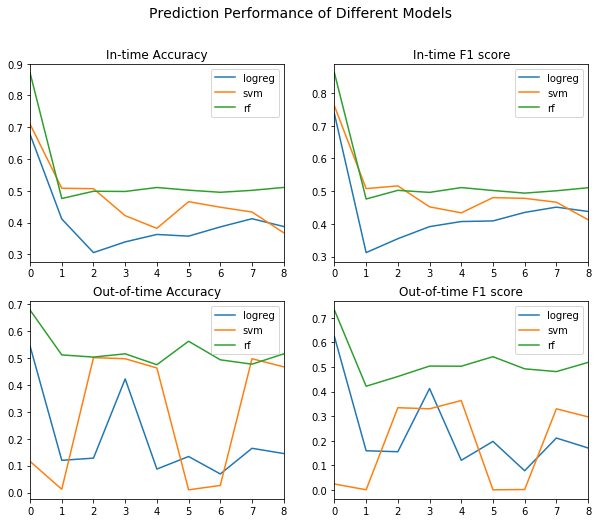

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 8))
fig.suptitle("Prediction Performance of Different Models", fontsize=14)
plot_prediction_score(model_accuracy_record10, axes[0,0])
axes[0,0].set_title('In-time Accuracy')
axes[0,1].set_title('In-time F1 score')
axes[1,0].set_title('Out-of-time Accuracy')
axes[1,1].set_title('Out-of-time F1 score')
plot_prediction_score(model_f1_score_record10, axes[0,1])
plot_prediction_score(model_new_accuracy_record10, axes[1,0])
plot_prediction_score(model_new_f1_score_record10, axes[1,1])

### Conclusion: Random Forest turned out to be consistent better than the other two, so it will be used in all prediction models from now on.

## Criteria Comparision: Pair Identification Methodology
* Criterion 1: Highest IR
* Criterion 2: Most Negative Correlation
* Criterion 3: Top Average Ranking
<br>*(Please refer to report for more details on methodology.)*

### Function: Calculate IR & Generate Equity Graph of Resulted Pairs Based on 3 Different Criteria

In [18]:
def compareStratGraph(whole_ret_ser,compare_list):
    print('\nComparison of the Information Ratio of Different Strategies (2002 -2019):\n')
    whole_ret_ser = whole_ret_ser10
    print('Prediction Strategy:',scoreSeries(whole_ret_ser,3))
    #
    growth_ser = calEquityGrowthGraph(whole_ret_ser)

    df_start_index = len(df)-len(whole_ret_ser)
    result_df = pd.DataFrame()
    result_df['Date'] = df[df_start_index:]['Date']
    result_df['BuyNHold_Return'] = df[df_start_index:]['eodRet']
    result_df['BuyNHold_Graph'] = calEquityGrowthGraph(result_df['BuyNHold_Return'])
    print('BuyNHold_Return:',scoreSeries(result_df['BuyNHold_Return'],3))

    for ret_col in compare_list:
        result_df[ret_col] = df[df_start_index:][ret_col]
        result_df[ret_col+'_Graph'] = calEquityGrowthGraph(result_df[ret_col])
        print(ret_col+':',scoreSeries(result_df[ret_col],3))
    

    result_df['Strat_Return'] = whole_ret_ser    
    result_df['Strat_Graph'] = growth_ser


    result_df.set_index('Date',inplace = True)

    fig, ax = plt.subplots(figsize=(20, 10))
    result_df.plot(ax = ax,kind='line', y='Strat_Graph',color = 'r')

    for ret_col in compare_list:
        result_df.plot(ax = ax,kind='line', y=ret_col+'_Graph')
    result_df.plot(ax = ax,kind='line', y='BuyNHold_Graph',color = 'grey')
    
    temp_df = result_df.reset_index()
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])

    start_date = pd.to_datetime('2007/12/13')
    end_date = pd.to_datetime('2008/11/29')
    selected_df = temp_df.loc[(temp_df['Date'] > start_date) & (temp_df['Date'] <= end_date)]
    print('\n\n2007/12/13' + ' to ' + '2008/11/29\n')
    print('Prediction Strategy:',scoreSeries(selected_df['Strat_Return'],3))
    print('BuyNHold_Return:',scoreSeries(selected_df['BuyNHold_Return'],3))
    for ret_col in compare_list:
        print(ret_col+':',scoreSeries(selected_df[ret_col],3))
    
    start_date = pd.to_datetime('2008/11/29')
    end_date = pd.to_datetime('2019/4/24')
    selected_df = temp_df.loc[(temp_df['Date'] > start_date) & (temp_df['Date'] <= end_date)]
    print('\n\n2008/11/29' + ' to ' + '2019/4/24\n')
    print('Prediction Strategy:',scoreSeries(selected_df['Strat_Return'],3))
    print('BuyNHold_Return:',scoreSeries(selected_df['BuyNHold_Return'],3))
    for ret_col in compare_list:
        print(ret_col+':',scoreSeries(selected_df[ret_col],3))
    
    

### Criterion 1: Highest IR
Choose the ones with highest IR among its own category based on data available up to that point.

In [19]:
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10 = testModel(piece_list10,pair_identification = 'ir')
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  EMA_30_260_Return SMA_30_260_Return
Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.7358310462535546
IR of the TF strategy: 0.3690368434219556
IR of the CT strategy: 0.23199866904421707
IR of average of the pair above: 0.3024229927137289


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  Long_20_2.2_Return Long_10_2.2_Return
Testing data date range:
2003/10/02
2005/09/15
IR of the prediction strategy: 0.0528039044680661
IR of the TF strategy: -0.017280962995846805
IR of the CT strategy: 0.014888032514110422
IR of average of the pair above: -0.0007473664303589662


Period  2
Length of training data: 1497
Training data date range:
1999/10/05
2005/09/16
The pair of strategy is:  Long_20_2.2_Return Long_10_2.2_Return
Testing data date range:
2005/09/26
2007/09/07
IR of the prediction 


Comparison of the Information Ratio of Different Strategies (2002 -2019):

Prediction Strategy: 0.365
BuyNHold_Return: 0.383
Long_20_2.2_Return: 0.709
Long_10_2.2_Return: 0.573


2007/12/13 to 2008/11/29

Prediction Strategy: 1.062
BuyNHold_Return: -1.081
Long_20_2.2_Return: 2.24
Long_10_2.2_Return: 2.401


2008/11/29 to 2019/4/24

Prediction Strategy: 0.201
BuyNHold_Return: 0.763
Long_20_2.2_Return: 0.393
Long_10_2.2_Return: 0.303


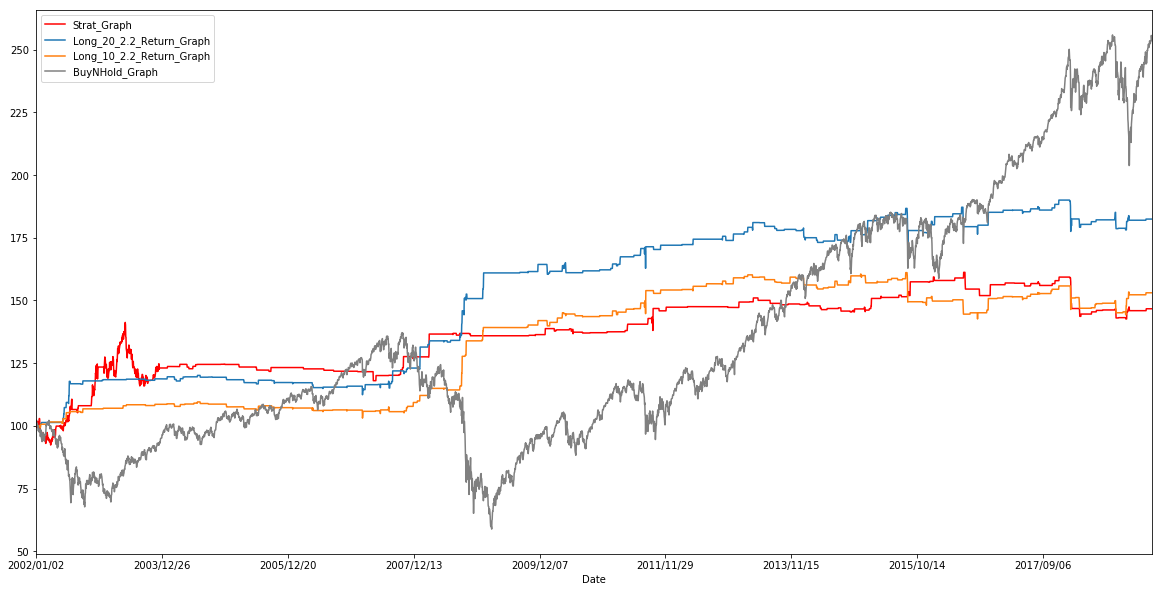

In [20]:
compareStratGraph(whole_ret_ser10,['Long_20_2.2_Return','Long_10_2.2_Return'])

In-time accuracy 0.8697653463850887
In-time f1 score 0.870815881318445
Out-of-time accuracy 0.8358158869829299
Out-of-time f1 score 0.8553998525776516


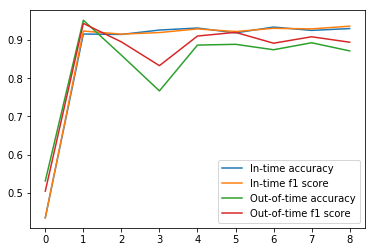

In [21]:
print('In-time accuracy',np.mean(whole_accuracy_record10))
plt.plot(whole_accuracy_record10,label = 'In-time accuracy')

print('In-time f1 score',np.mean(whole_f1_score_record10))
plt.plot(whole_f1_score_record10,label = 'In-time f1 score')

print('Out-of-time accuracy',np.mean(whole_new_accuracy_record10))
plt.plot(whole_new_accuracy_record10,label = 'Out-of-time accuracy')

print('Out-of-time f1 score',np.mean(whole_new_f1_score_record10))
plt.plot(whole_new_f1_score_record10,label = 'Out-of-time f1 score')

plt.legend()

### Criterion 2: Most Negative Correlation
Choose the two strategies that have most negative correlation based on data available up to that point.

In [22]:
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10 = testModel(piece_list10,pair_identification = 'corr')
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  SMA_60_260_Return EMA_30_260_Return
Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.5397469525739694
IR of the TF strategy: 0.23199866904421707
IR of the CT strategy: 0.14498591509614484
IR of average of the pair above: 0.18870517929426242


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  EMA_30_100_Return eodRet
Testing data date range:
2003/10/02
2005/09/15
IR of the prediction strategy: 0.36187244692764525
IR of the TF strategy: 0.9785825490042183
IR of the CT strategy: 0.06592364695869275
IR of average of the pair above: 0.5729830056944263


Period  2
Length of training data: 1497
Training data date range:
1999/10/05
2005/09/16
The pair of strategy is:  EMA_30_100_Return eodRet
Testing data date range:
2005/09/26
2007/09/07
IR of the prediction strategy: 0.5565213315173514
IR


Comparison of the Information Ratio of Different Strategies (2002 -2019):

Prediction Strategy: 0.223
BuyNHold_Return: 0.383
SMA_10_150_Return: 0.194
EMA_30_100_Return: 0.114


2007/12/13 to 2008/11/29

Prediction Strategy: -1.283
BuyNHold_Return: -1.081
SMA_10_150_Return: 1.021
EMA_30_100_Return: 0.864


2008/11/29 to 2019/4/24

Prediction Strategy: 0.362
BuyNHold_Return: 0.763
SMA_10_150_Return: 0.175
EMA_30_100_Return: 0.023


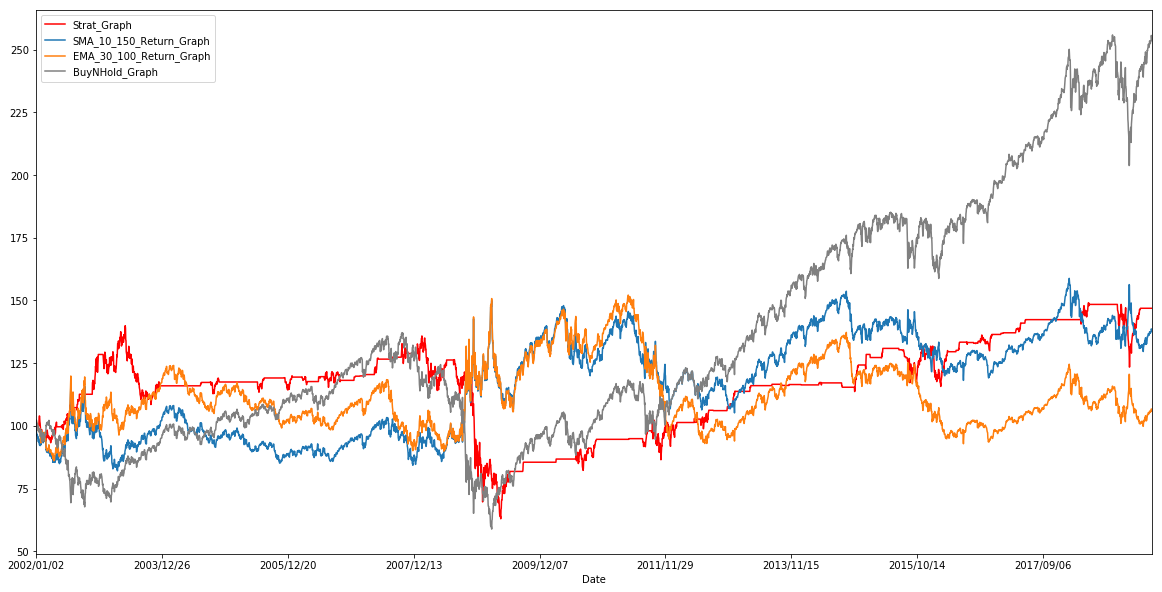

In [23]:
compareStratGraph(whole_ret_ser10,['SMA_10_150_Return','EMA_30_100_Return'])

In-time accuracy 0.4613773748528102
In-time f1 score 0.37606376176233364
Out-of-time accuracy 0.4440580830033163
Out-of-time f1 score 0.3350534886031476


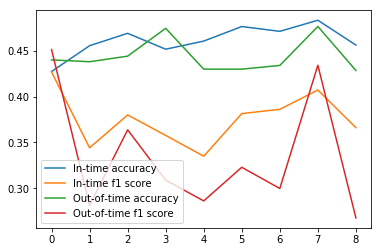

In [24]:
print('In-time accuracy',np.mean(whole_accuracy_record10))
plt.plot(whole_accuracy_record10,label = 'In-time accuracy')

print('In-time f1 score',np.mean(whole_f1_score_record10))
plt.plot(whole_f1_score_record10,label = 'In-time f1 score')

print('Out-of-time accuracy',np.mean(whole_new_accuracy_record10))
plt.plot(whole_new_accuracy_record10,label = 'Out-of-time accuracy')

print('Out-of-time f1 score',np.mean(whole_new_f1_score_record10))
plt.plot(whole_new_f1_score_record10,label = 'Out-of-time f1 score')

plt.legend()

### Criterion 3: Top Average Ranking on Criteron 1&2
Choose the pair that has the top average ranking on highest IR and most negative correlation, based on data available up to that point.

In [25]:
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10 = testModel(piece_list10,pair_identification = 'sum')
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  SMA_60_260_Return SMA_30_260_Return
Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.5397469525739694
IR of the TF strategy: 0.3690368434219556
IR of the CT strategy: 0.14498591509614484
IR of average of the pair above: 0.2589276571937213


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  Short_30_1.4_Return SMA_10_260_Return
Testing data date range:
2003/10/02
2005/09/15
IR of the prediction strategy: 0.6289971334985838
IR of the TF strategy: 0.43012873931445217
IR of the CT strategy: -0.6698952540956354
IR of average of the pair above: 0.1546651368307421


Period  2
Length of training data: 1497
Training data date range:
1999/10/05
2005/09/16
The pair of strategy is:  Short_30_1.4_Return EMA_60_150_Return
Testing data date range:
2005/09/26
2007/09/07
IR of the prediction strateg


Comparison of the Information Ratio of Different Strategies (2002 -2019):

Prediction Strategy: 0.087
BuyNHold_Return: 0.383
Long_10_1.4_Return: 0.801
EMA_10_60_Return: 0.265


2007/12/13 to 2008/11/29

Prediction Strategy: 0.636
BuyNHold_Return: -1.081
Long_10_1.4_Return: 0.299
EMA_10_60_Return: 0.999


2008/11/29 to 2019/4/24

Prediction Strategy: -0.221
BuyNHold_Return: 0.763
Long_10_1.4_Return: 1.059
EMA_10_60_Return: 0.16


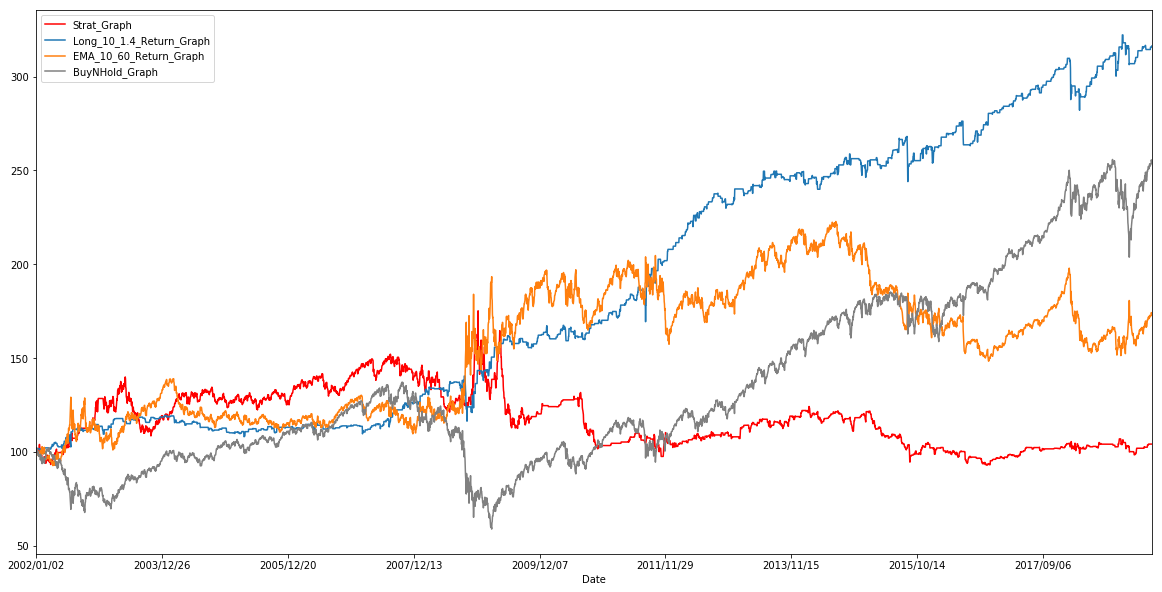

In [26]:
compareStratGraph(whole_ret_ser10,['Long_10_1.4_Return','EMA_10_60_Return'])

In-time accuracy 0.4447847541040596
In-time f1 score 0.4510301488476013
Out-of-time accuracy 0.38287693254410393
Out-of-time f1 score 0.3657654869744806


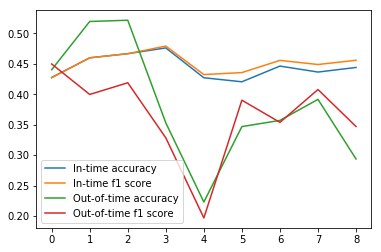

In [27]:
print('In-time accuracy',np.mean(whole_accuracy_record10))
plt.plot(whole_accuracy_record10,label = 'In-time accuracy')

print('In-time f1 score',np.mean(whole_f1_score_record10))
plt.plot(whole_f1_score_record10,label = 'In-time f1 score')

print('Out-of-time accuracy',np.mean(whole_new_accuracy_record10))
plt.plot(whole_new_accuracy_record10,label = 'Out-of-time accuracy')

print('Out-of-time f1 score',np.mean(whole_new_f1_score_record10))
plt.plot(whole_new_f1_score_record10,label = 'Out-of-time f1 score')

plt.legend()

### Ultimate Criterion: Complement Finding

Choose the strategy with highest IR as a base strategy, and then find a second strategy that has highest returns on days when first strategy has worst performance (bottom 10% returns).<br><br>*Please refer to report for more reasoning for this criterion.*

In [28]:
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10 = testModel(piece_list10,pair_identification = 'complement')
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  Short_30_2.6_Return Short_30_1.4_Return
Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.5435522688170892
IR of the TF strategy: 0.8066945070163638
IR of the CT strategy: -0.39002496808002485
IR of average of the pair above: 0.6994291822384486


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  Long_20_2.2_Return SMA_60_100_Return
Testing data date range:
2003/10/02
2005/09/15
IR of the prediction strategy: 0.2761450065808146
IR of the TF strategy: 0.18900505991905506
IR of the CT strategy: 0.014888032514110422
IR of average of the pair above: 0.18918302398862336


Period  2
Length of training data: 1497
Training data date range:
1999/10/05
2005/09/16
The pair of strategy is:  Long_20_2.2_Return SMA_60_100_Return
Testing data date range:
2005/09/26
2007/09/07
IR of the prediction st


Comparison of the Information Ratio of Different Strategies (2002 -2019):

Prediction Strategy: 0.61
BuyNHold_Return: 0.383
Long_20_2.2_Return: 0.709
SMA_10_30_Return: 0.069


2007/12/13 to 2008/11/29

Prediction Strategy: 1.553
BuyNHold_Return: -1.081
Long_20_2.2_Return: 2.24
SMA_10_30_Return: 0.491


2008/11/29 to 2019/4/24

Prediction Strategy: 0.657
BuyNHold_Return: 0.763
Long_20_2.2_Return: 0.393
SMA_10_30_Return: -0.024


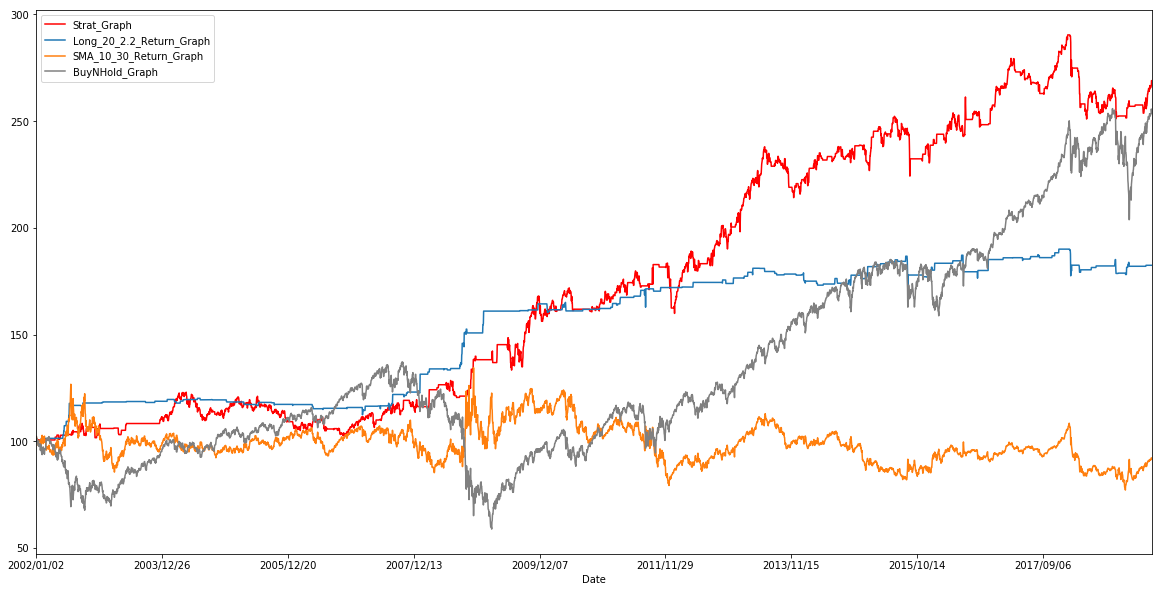

In [29]:
compareStratGraph(whole_ret_ser10,['Long_20_2.2_Return','SMA_10_30_Return'])

In-time accuracy 0.536
In-time f1 score 0.539
Out-of-time accuracy 0.525
Out-of-time f1 score 0.517


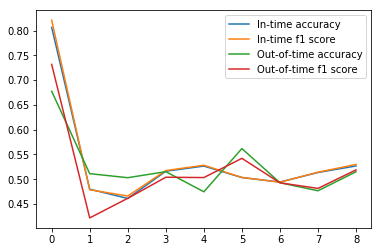

In [30]:
print('In-time accuracy',round(np.mean(whole_accuracy_record10),3))
plt.plot(whole_accuracy_record10,label = 'In-time accuracy')

print('In-time f1 score',round(np.mean(whole_f1_score_record10),3))
plt.plot(whole_f1_score_record10,label = 'In-time f1 score')

print('Out-of-time accuracy',round(np.mean(whole_new_accuracy_record10),3))
plt.plot(whole_new_accuracy_record10,label = 'Out-of-time accuracy')

print('Out-of-time f1 score',round(np.mean(whole_new_f1_score_record10),3))
plt.plot(whole_new_f1_score_record10,label = 'Out-of-time f1 score')

plt.legend()

### Conclusion: Different creteria lead to very different predictability and profitability of the final model. Our ultimate criterion (complement finding) has the best performance.
* Criterion 1 Highest IR: Turns out to be a final model with great predictability, but doesn't have the trend-following aspect that captures the trending times of the market. 
* Criterion 2 Most Negative Correlation & Criterion 3 Top Avg Ranking: Turns out to be a final model with too low accuracy thus not reliable. 
* **Ultimate Criterion Complement Finding:** Proves to be the most consistent one. Though it only predicts slightly better than random on average, it adds value to the trading decision, which will be proved in later analysis.

### Model Evaluation: Decisions During Crisis & Non-Crisis Periods
Here we take a closer look at decisions made by our model to verify that our model is making sensible strategy decisions.

In [31]:
whole_d_seq10_conti = []
for arr in whole_d_seq10:
    whole_d_seq10_conti += list(arr)

In [32]:
whole_data_range10_conti = []
for arr in whole_data_range10:
    whole_data_range10_conti += list(arr)

In [33]:
d_seq_df = pd.DataFrame(list(zip(whole_data_range10_conti, whole_d_seq10_conti)), columns=['Date','Decision'])

In [34]:
d_seq_df['Date'] = pd.to_datetime(d_seq_df['Date'])
d_seq_df.set_index('Date',inplace = True)

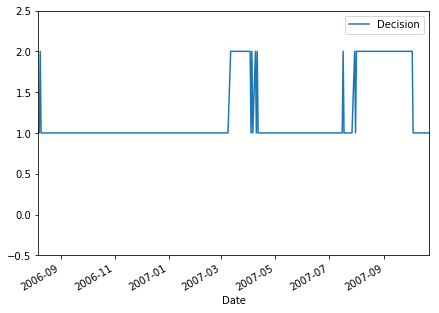

In [35]:
d_seq_df[1200:1500].plot(figsize = (7,5),ylim=(-0.5,2.5))

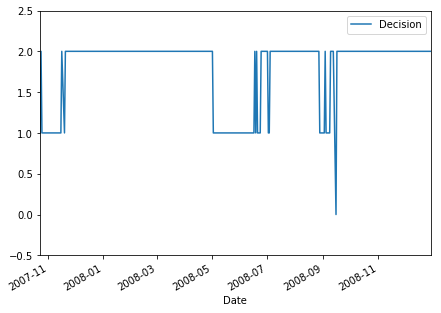

In [36]:
d_seq_df[1500:1800].plot(figsize = (7,5),ylim=(-0.5,2.5))

### Conclusion: Our model is dynamically reacting to the market and making sensible strategy decisions.
* 2006-2007: Our model is mostly using trend-following strategy when a trending period leading up to the crisis. 
* 2008 Financial Crisis: Our model decides to use mostly counter-trend strategy or not trading. <br>**All of these are great signs that our model is performing well, and dynamically making sensible strategy in both crisis and non-crisis periods.**


### Subtask: Y Variable Choice - Binary vs. Ternary Classification
We specified two kinds of classification task for ML models:
* Binary classification: TF or CT.
* Ternary classification: TF or CT or OFF.
<br>*Please refer to report for more details on this subtask.

<br>**Ternary results are shown in the last example of previous section, below are the results of a binary classification.**

In [51]:
whole_ret_ser10,whole_d_seq10,whole_data_range10,whole_accuracy_record10,whole_f1_score_record10,whole_new_accuracy_record10,whole_new_f1_score_record10 = testModel(piece_list10,pair_identification = 'complement',split_class = 2)
print(len(whole_ret_ser10))
print(scoreSeries(whole_ret_ser10))

Period  0
Length of training data: 499
Training data date range:
1999/10/05
2001/10/01
The pair of strategy is:  Short_30_2.6_Return Short_30_1.4_Return
Testing data date range:
2001/10/09
2003/09/23
IR of the prediction strategy: 0.5435522688170892
IR of the TF strategy: 0.8066945070163638
IR of the CT strategy: -0.39002496808002485
IR of average of the pair above: 0.6994291822384486


Period  1
Length of training data: 998
Training data date range:
1999/10/05
2003/09/24
The pair of strategy is:  Long_20_2.2_Return SMA_60_100_Return
Testing data date range:
2003/10/02
2005/09/15
IR of the prediction strategy: 0.2882150495438951
IR of the TF strategy: 0.18900505991905506
IR of the CT strategy: 0.014888032514110422
IR of average of the pair above: 0.18918302398862336


Period  2
Length of training data: 1497
Training data date range:
1999/10/05
2005/09/16
The pair of strategy is:  Long_20_2.2_Return SMA_60_100_Return
Testing data date range:
2005/09/26
2007/09/07
IR of the prediction st


Comparison of the Information Ratio of Different Strategies (2002 -2019):

Prediction Strategy: 0.454
BuyNHold_Return: 0.383
Long_20_2.2_Return: 0.709
SMA_10_30_Return: 0.069


2007/12/13 to 2008/11/29

Prediction Strategy: 0.776
BuyNHold_Return: -1.081
Long_20_2.2_Return: 2.24
SMA_10_30_Return: 0.491


2008/11/29 to 2019/4/24

Prediction Strategy: 0.442
BuyNHold_Return: 0.763
Long_20_2.2_Return: 0.393
SMA_10_30_Return: -0.024


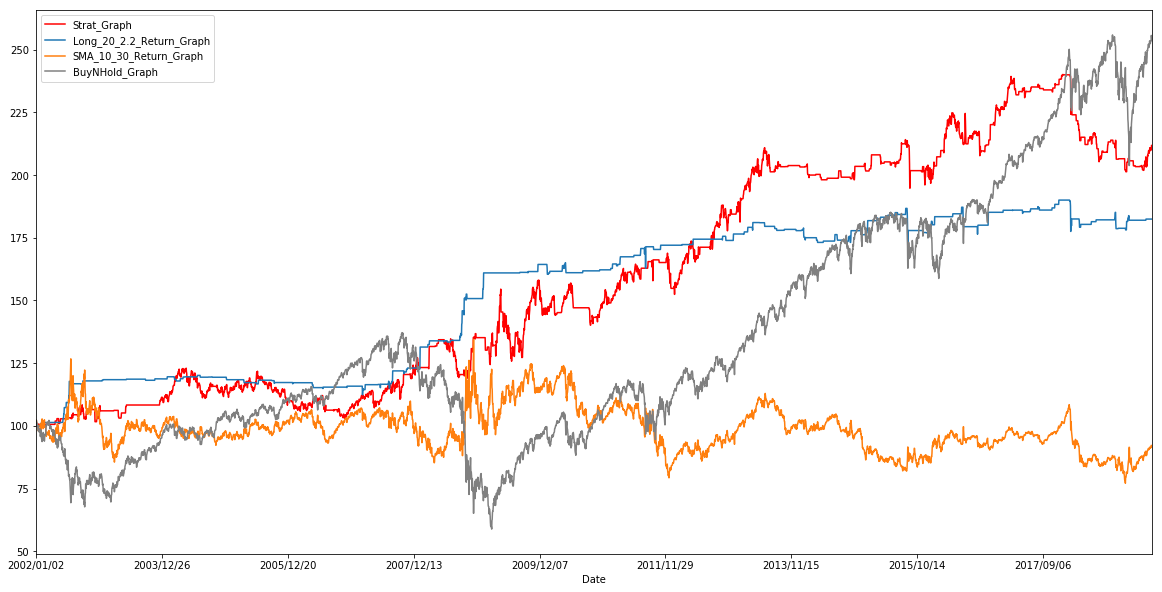

In [53]:
compareStratGraph(whole_ret_ser10,['Long_20_2.2_Return','SMA_10_30_Return'])

In-time accuracy 0.541
In-time f1 score 0.542
Out-of-time accuracy 0.533
Out-of-time f1 score 0.498


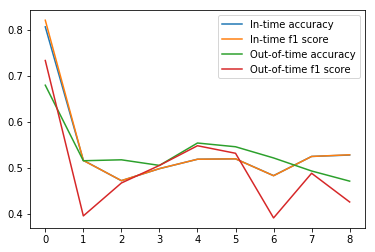

In [57]:
print('In-time accuracy',round(np.mean(whole_accuracy_record10),3))
plt.plot(whole_accuracy_record10,label = 'In-time accuracy')

print('In-time f1 score',round(np.mean(whole_f1_score_record10),3))
plt.plot(whole_f1_score_record10,label = 'In-time f1 score')

print('Out-of-time accuracy',round(np.mean(whole_new_accuracy_record10),3))
plt.plot(whole_new_accuracy_record10,label = 'Out-of-time accuracy')

print('Out-of-time f1 score',round(np.mean(whole_new_f1_score_record10),3))
plt.plot(whole_new_f1_score_record10,label = 'Out-of-time f1 score')

plt.legend()

### Model Evaluation: Our Combined Strategy in Trending Markets & Volatile Markets <br>(Compared w/ Best Strategeies Selected from 2001-2010, Tested on 2011-2019 Data)
Here we draw a comparison between our combined strategy and the strategies that perform best during 2001-2010 (a period with crisis) based on their performance in 2011-2019 (a period without crisis), to verify that our combined strategy behaves consistantly good under different market conditions.

In [43]:
def periodBestStrats(df,start_index,end_index,top = 3):
    start = start_index
    end = end_index

    top_strategies = []
    while len(top_strategies)<2:
        max_score = 0
        best_strategy = ''
        for col in [col for col in df.columns if 'Return' in col and '1.4' not in col and col not in top_strategies]:
            score = scoreSeries(df[start:end][col])
            if score > max_score:
                max_score = score
                best_strategy = col
        top_strategies.append(best_strategy)
    
    
    ret_ser1 = list(df['eodRet'][start:end])
    ret_ser2 = list(df['Long_20_2.2_Return'][start:end])

    average_of_eodRet_and_CT = []
    for i in range(len(ret_ser1)):
        average_of_eodRet_and_CT.append((ret_ser1[i]+ret_ser2[i])/2)

    comparison_df = pd.DataFrame()

    comparison_df['Date'] = df['Date'][start:end]

    Strategy_name = 'Strat_Return'
    comparison_df[Strategy_name] = whole_ret_ser10[-len(df[start:end]):]
    print(Strategy_name,scoreSeries(comparison_df[Strategy_name],3))
    comparison_df[Strategy_name+'_Graph'] = calEquityGrowthGraph(comparison_df[Strategy_name])
    
    Strategy_name = 'average_eodRet_and_CT_Return'
    comparison_df[Strategy_name] = average_of_eodRet_and_CT
    print(Strategy_name,scoreSeries(comparison_df[Strategy_name],3))
    comparison_df[Strategy_name+'_Graph'] = calEquityGrowthGraph(comparison_df[Strategy_name])
    
    
    for col in top_strategies:
        comparison_df[col] = df[col][start:end]
        print(col,scoreSeries(comparison_df[col],3))
        comparison_df[col+'_Graph'] = calEquityGrowthGraph(comparison_df[col])


    comparison_df.set_index('Date',inplace = True)
    fig, ax = plt.subplots(figsize=(20, 10))

    for col in [col for col in comparison_df.columns if '_Graph' in col]:
        if col.startswith('Strat_'):
            comparison_df.plot(ax = ax,kind='line', y= col,c='red')
        else:
            comparison_df.plot(ax = ax,kind='line', y= col)
    
    return top_strategies


Strat_Return 0.752
average_eodRet_and_CT_Return 0.404
Long_20_2.2_Return 1.062
Long_10_2.2_Return 0.998


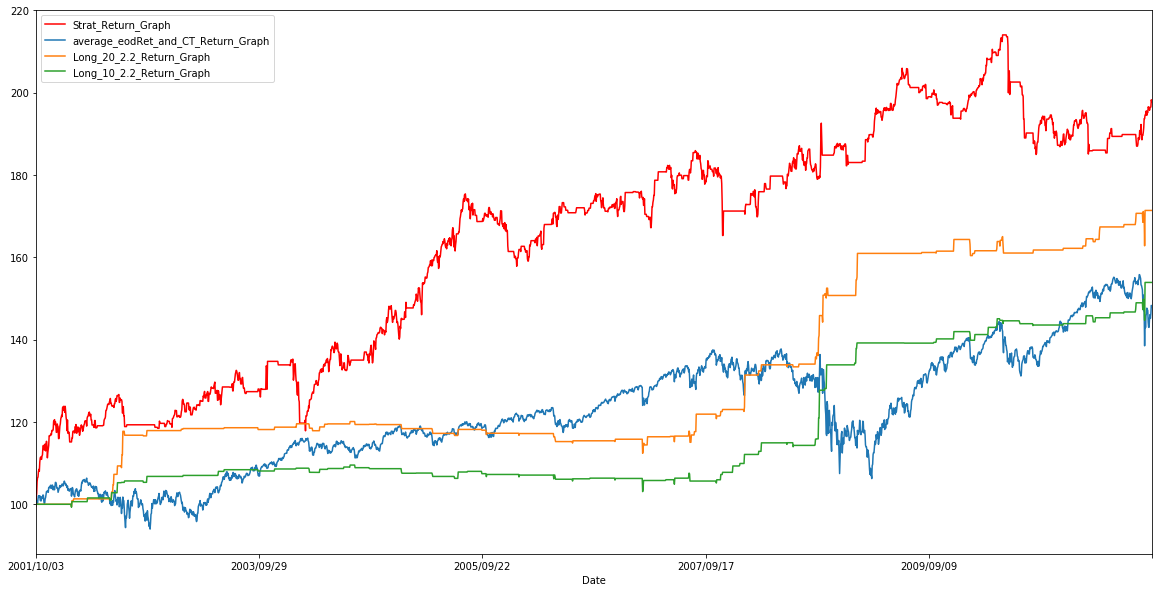

In [44]:
top_strategies_crisis = periodBestStrats(df,500,3000)

Strat_Return 0.772
average_eodRet_and_CT_Return 0.789
Short_30_0.6_Return 0.96
Short_20_0.6_Return 0.94


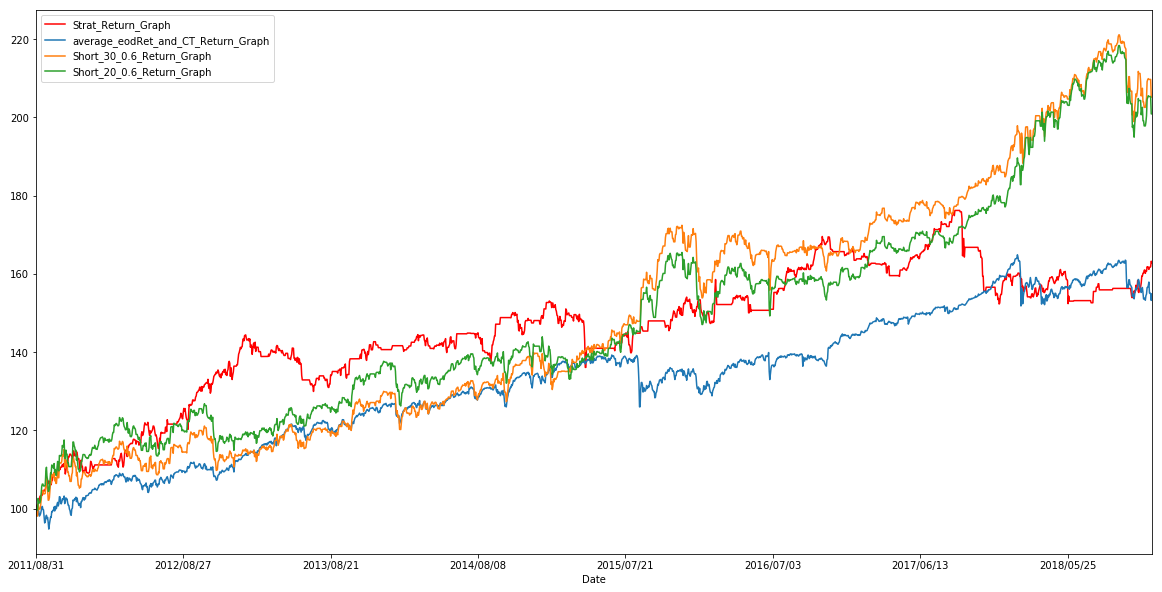

In [45]:
top_strategies_normal = periodBestStrats(df,3000,len(df)-100)

In [46]:
def periodComparison(df,start_index,end_index,specific_strategies = ['Long_20_2.2_Return','SMA_10_30_Return']):
    start = start_index
    end = end_index

    ret_ser1 = list(df['eodRet'][start:end])
    ret_ser2 = list(df['Long_20_2.2_Return'][start:end])

    average_of_eodRet_and_CT = []
    for i in range(len(ret_ser1)):
        average_of_eodRet_and_CT.append((ret_ser1[i]+ret_ser2[i])/2)

    comparison_df = pd.DataFrame()

    comparison_df['Date'] = df['Date'][start:end]

    
    Strategy_name = 'Strat_Return'
    comparison_df[Strategy_name] = whole_ret_ser10[-len(df[start:end]):]
    print(Strategy_name,scoreSeries(comparison_df[Strategy_name],3))
    comparison_df[Strategy_name+'_Graph'] = calEquityGrowthGraph(comparison_df[Strategy_name])
    

    Strategy_name = 'average_eodRet_and_CT_Return'
    comparison_df[Strategy_name] = average_of_eodRet_and_CT
    print(Strategy_name,scoreSeries(comparison_df[Strategy_name],3))
    comparison_df[Strategy_name+'_Graph'] = calEquityGrowthGraph(comparison_df[Strategy_name])
    
    
    
    for col in ['eodRet']+specific_strategies:
        comparison_df[col] = df[col][start:end]
        print(col,scoreSeries(comparison_df[col],3))
        comparison_df[col+'_Graph'] = calEquityGrowthGraph(comparison_df[col])


    comparison_df.set_index('Date',inplace = True)
    fig, ax = plt.subplots(figsize=(20, 10))

    for col in [col for col in comparison_df.columns if '_Graph' in col]:
        if col.startswith('Strat_'):
            comparison_df.plot(ax = ax,kind='line', y= col,c='red')
        else:
            comparison_df.plot(ax = ax,kind='line', y= col)


### Equity Graph Comparison: 2011-2019 Period
<br>**Below we plot the equity graph of the top two strategies selected from 2001-2010 (a 10-year period that has a crisis), BuyNHold, equal weighting of 2 base strategies, and our combined strategies.**

Strat_Return 0.772
average_eodRet_and_CT_Return 0.789
eodRet 0.848
Long_20_2.2_Return 0.187
Long_10_2.2_Return -0.042


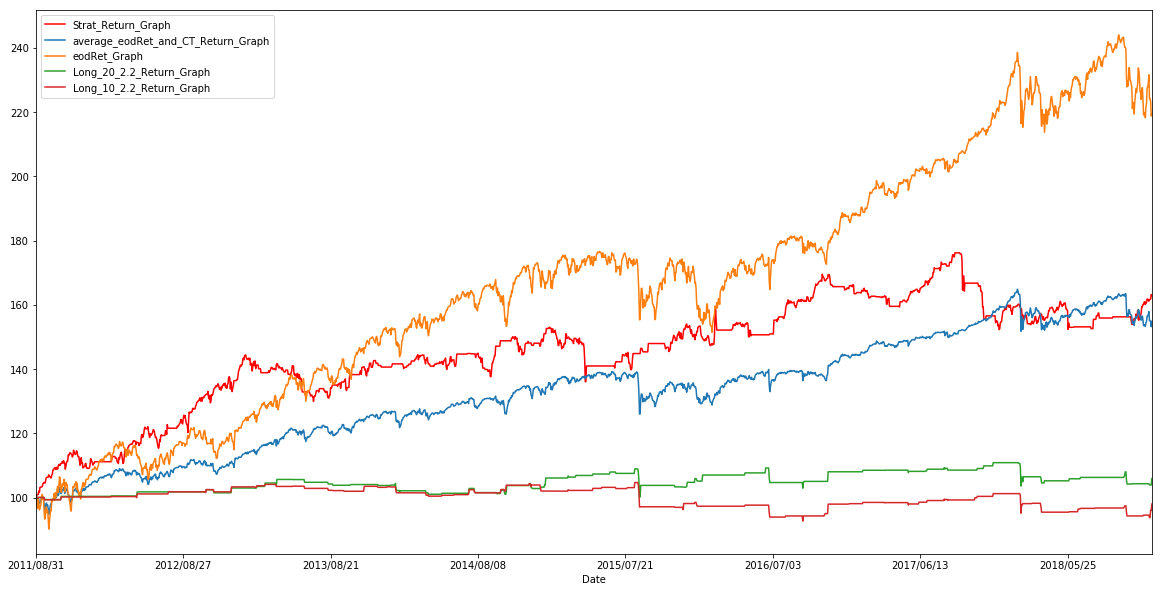

In [47]:
periodComparison(df,3000,len(df)-100,top_strategies_crisis)

### Equity Graph Comparison: 2001-2010 Period
<br>**Below we plot the equity graph of the top two strategies selected from 2001-2010 (a 10-year period that has a crisis), BuyNHold, equal weighting of 2 base strategies, and our combined strategies.**

Strat_Return 0.752
average_eodRet_and_CT_Return 0.404
eodRet 0.173
Short_30_0.6_Return 0.059
Short_20_0.6_Return -0.062


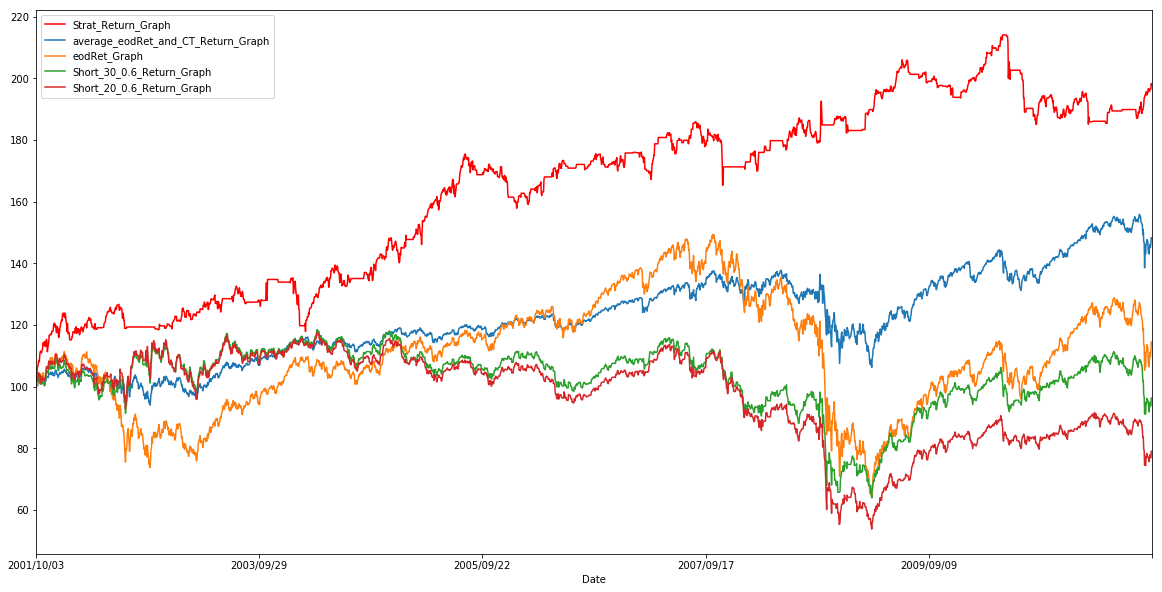

In [48]:
periodComparison(df,500,3000,top_strategies_normal)

### Equity Graph: Combined Strategy vs. 2 Component Strategies (2001-2010)

eodRet 0.173
Long_20_2.2_Return 1.062
SMA_10_30_Return 0.091
Strat_Return 0.752


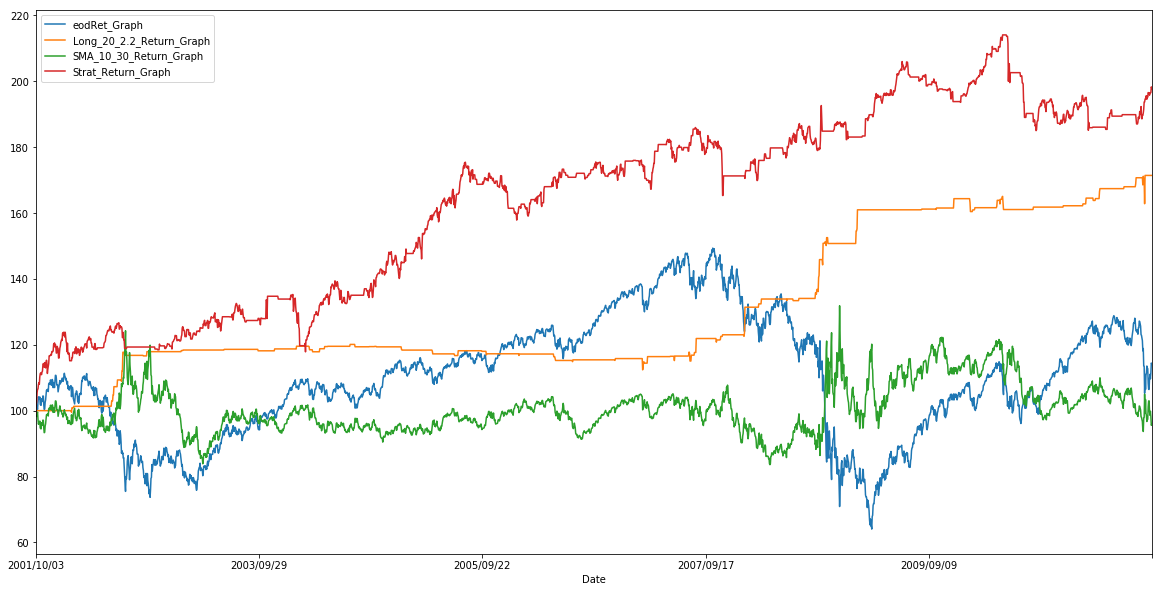

In [35]:
periodComparison(df,500,3000)

### Equity Graph: Combined Strategy vs. 2 Component Strategies (2011-2019)

eodRet 0.848
Long_20_2.2_Return 0.187
SMA_10_30_Return -0.112
Strat_Return 0.772


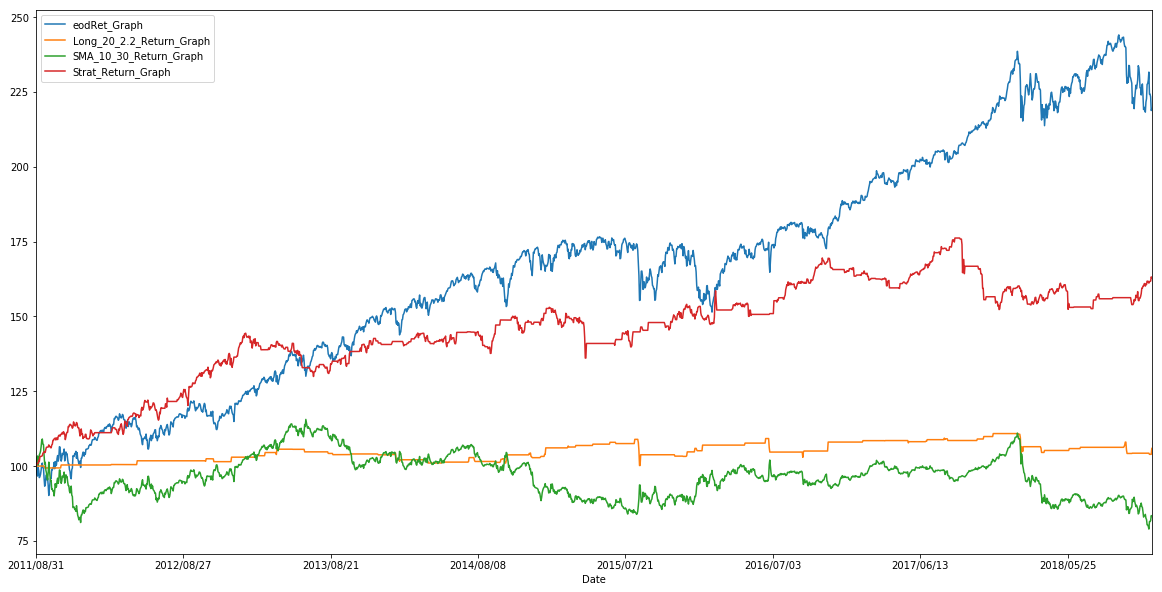

In [36]:
periodComparison(df,3000,len(df)-100)

### Equity Graph: Whole Period Comparison (2001-2019)
<br>**Below we plot the equity graph of the top two strategies selected from 2001-2010 (a 10-year period that has a crisis), BuyNHold, 2 component strategies, equal weighting of the best-performed CT and BuyNHold and our combined strategies.**

Strat_Return 0.61
average_eodRet_and_CT_Return 0.525
eodRet 0.381
Long_20_2.2_Return 0.707
SMA_10_30_Return 0.025


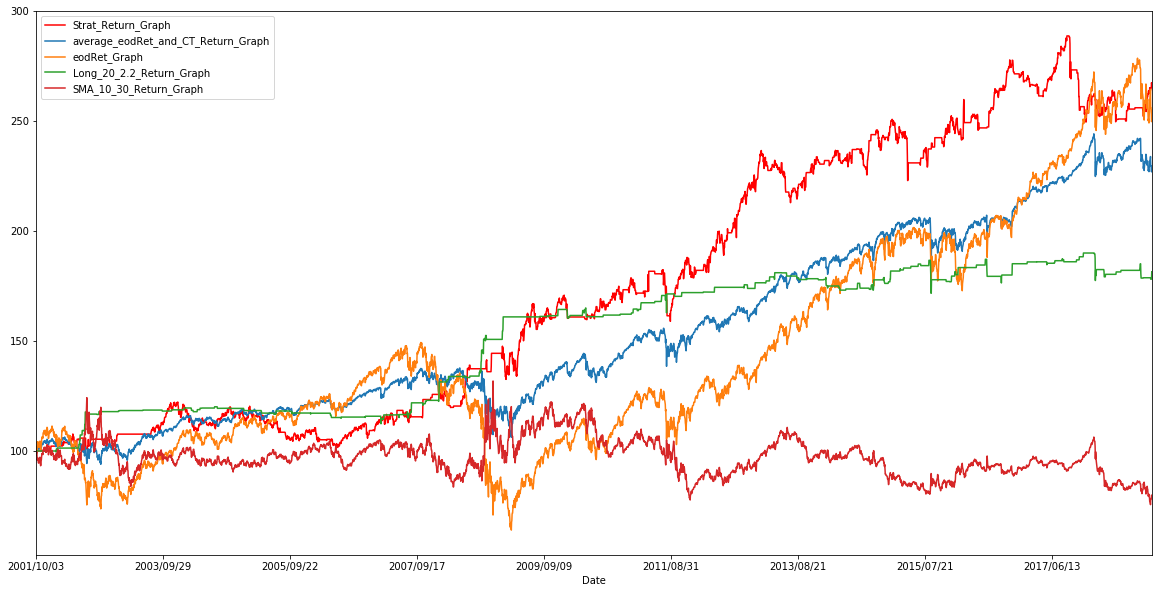

In [49]:
periodComparison(df,500,len(df)-100)

### Conclusions: 
* **Our combined strategy has an IR of 0.61 > 0.525 (simple average of best-performed CT & BuyNHold) in the whole period (2001-2019). This means that our ML-based on/off switch adds value to the simple combination of best-performed CT and BuyNhold, or the best-performed CT with any other TFs.**
<br>
* **The strength of our ML model is triggered more obviously during crisis time where our strategy outperforms the simple average strategy by 0.35 in IR.**

### Appendix: IR of Different CT Strategies (1999-2019)

In [125]:
def genTwoDScoreDF(data,formatString,firstRange,secondRange,show = False,image_name = ''):
    twoD_df = pd.DataFrame(np.nan, index = firstRange, columns = secondRange)
    for first in twoD_df.index:
        for second in  twoD_df.columns:
            try:
                twoD_df.loc[first,second] = scoreSeries(data[formatString % (first,second)])
            except:
                twoD_df.loc[first,second] = np.nan
    if show or len(image_name)>0:
        plt.figure(figsize = (10*len(secondRange)/len(firstRange),10))
        sns.heatmap(twoD_df,cmap = 'coolwarm',annot = True)
        if len(image_name)>0:
            plt.savefig( image_name+'.png', dpi=300)
    return twoD_df

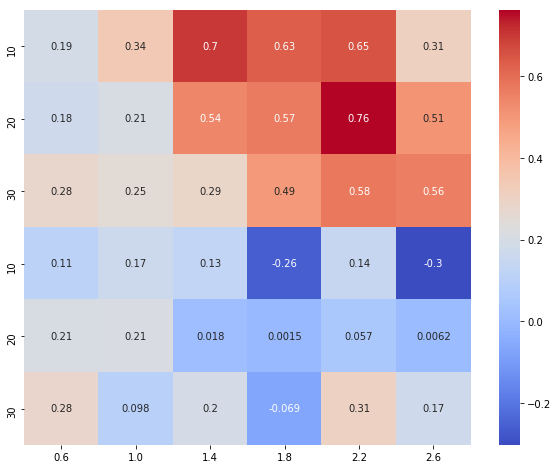

In [136]:
data = df
short_ct_df = genTwoDScoreDF(data,'Short_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
long_ct_df = genTwoDScoreDF(data,'Long_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
temp = long_ct_df.append(short_ct_df)
plt.figure(figsize = (10,8))
sns.heatmap(temp,cmap = 'coolwarm',annot = True)
#plt.savefig('CT.png', dpi=300)

### Appendix: IR of Different CT Strategies (2001-2010)

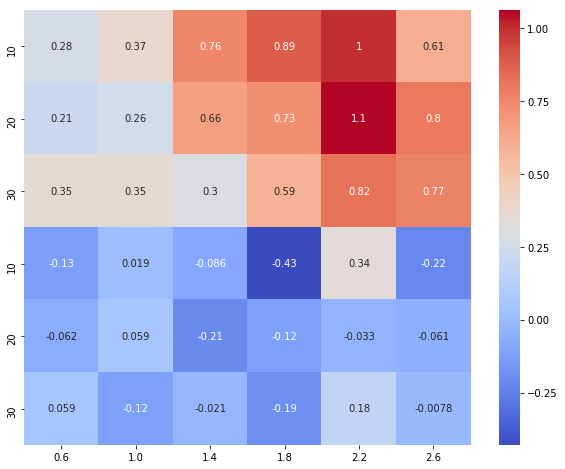

In [138]:
# Including crisis
data = df[500:3000]
short_ct_df = genTwoDScoreDF(data,'Short_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
long_ct_df = genTwoDScoreDF(data,'Long_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
temp = long_ct_df.append(short_ct_df)
plt.figure(figsize = (10,8))
sns.heatmap(temp,cmap = 'coolwarm',annot = True)
#plt.savefig('CT.png', dpi=300)

### Appendix: IR of Different CT Strategies (2011-2019)

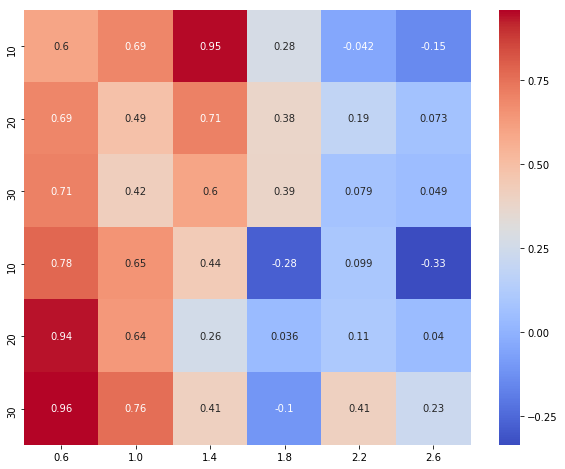

In [137]:
# After crisis
data = df[3000:len(df)-100]
short_ct_df = genTwoDScoreDF(data,'Short_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
long_ct_df = genTwoDScoreDF(data,'Long_%d_%.1f_Return',[10,20,30],[x/10 for x in range(6,30,4)])
temp = long_ct_df.append(short_ct_df)
plt.figure(figsize = (10,8))
sns.heatmap(temp,cmap = 'coolwarm',annot = True)
#plt.savefig('CT.png', dpi=300)

### Appendix: IR of Different TF Strategies (1999-2019)

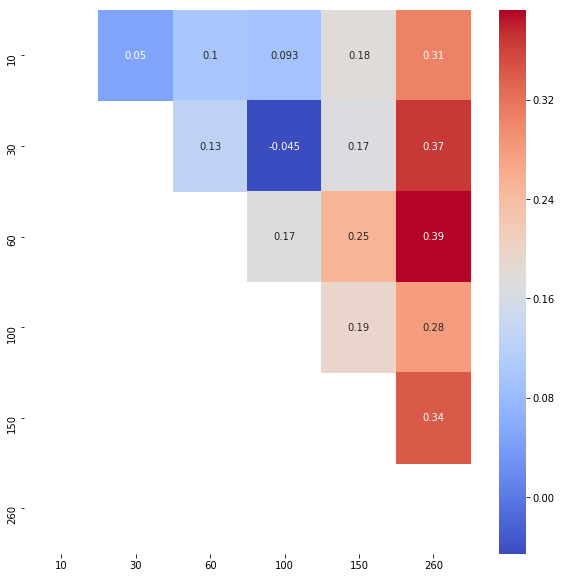

In [124]:
sma_df = genTwoDScoreDF(df,'SMA_%d_%d_Return',[10,30,60,100,150,260],[10,30,60,100,150,260], image_name = 'TF_IR')